In [157]:
from qiskit.circuit.library import QuantumVolume as QuantumVolumeCircuit
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.visualization import plot_histogram
from qiskit import transpile, execute, Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [80]:
# from https://learn.qiskit.org/course/quantum-hardware/measuring-quantum-volume
def get_heavy_outputs(counts):
    """Extract heavy outputs from counts dict.
    Args:
        counts (dict): Output of `.get_counts()`
    Returns:
        list: All states with measurement probability greater
              than the mean.
    """
    # sort the keys of `counts` by value of counts.get(key)
    sorted_counts = sorted(counts.keys(), key=counts.get)
    # discard results with probability < median
    heavy_outputs = sorted_counts[len(sorted_counts)//2:]
    return heavy_outputs

def check_threshold(nheavies, ncircuits, nshots):
    """Evaluate adjusted threshold inequality for quantum volume.
    Args:
        nheavies (int): Total number of heavy outputs measured from device
        ncircuits (int): Number of different square circuits run on device
        nshots (int): Number of shots per circuit
    Returns:
        Bool:
            True if heavy output probability is > 2/3 with 97% certainty,
            otherwise False
    """
    from numpy import sqrt
    numerator = nheavies - 2*sqrt(nheavies*(nshots-(nheavies/ncircuits)))
    return bool(numerator/(ncircuits*nshots) > 2/3)

In [83]:
def test_qv(nqubits, ncircuits, nshots, noise_model):
    def get_ideal_probabilities(circuit):
        """Simulates circuit behaviour on a device with no errors."""
        state_vector = Statevector.from_instruction(
                circuit.remove_final_measurements(inplace=False)
            )
        return state_vector.probabilities_dict(), state_vector 

    def get_real_counts(circuit, shots):
        """Runs circuit on device and returns counts dict."""
        sim_noise = AerSimulator(noise_model=noise_model)
        t_circuit = transpile(circuit, sim_noise)
        job = sim_noise.run(t_circuit, shots=shots, memory=True)
        return job.result().get_counts(), job.result().data().get('density_matrix')

    # generate set of random circuits
    qv_circuits = [
        QuantumVolumeCircuit(nqubits) for c in range(ncircuits)
    ]
    fids = []
    nheavies = 0  # number of measured heavy outputs
    for circuit in qv_circuits:
        # simulate circuit
        ps, sv = get_ideal_probabilities(circuit)
        ideal_heavy_outputs = get_heavy_outputs(ps)
        circuit.save_density_matrix()
        # run circuit on device
        circuit.measure_all()
        circuit = circuit.decompose()
        real_counts, dm = get_real_counts(circuit, nshots)
        fids.append(state_fidelity(sv, dm))
        # record whether device result is in the heavy outputs
        for output, count in real_counts.items():
            if output in ideal_heavy_outputs:
                nheavies += count

    # do statistical check to see if device passes test
    is_pass = check_threshold(nheavies, ncircuits, nshots)
    # calculate percentage of measurements that are heavy outputs
    percent_heavy_outputs = nheavies*100/(ncircuits * nshots)
    fid = np.mean(fids)

    #print(f"Quantum Volume: {2**nqubits}\n"
    #      f"Percentage Heavy Outputs: {percent_heavy_outputs:.1f}%\n"
    #      f"Passed?: {is_pass}\n"
    #      f"Fidelity: {fid} \n")
    return percent_heavy_outputs / 100, fid

In [100]:
rep = 160
shots = 1024
p_range = np.linspace(0.0, 0.1, 20)
qubit_range = [3, 4, 5, 6, 8, 10]
hops = []
fids = []

for num_qubits in qubit_range:
    hops.append([])
    fids.append([])

    for p_error in p_range:
        print(p_error)
        error_gate = depolarizing_error(p_error, 2)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(error_gate, ['cx'])
        h, f = test_qv(num_qubits, rep, shots, noise_model)
        hops[-1].append(h)
        fids[-1].append(f)

0.0
0.005263157894736842
0.010526315789473684
0.015789473684210527
0.021052631578947368
0.02631578947368421
0.031578947368421054
0.03684210526315789
0.042105263157894736
0.04736842105263158
0.05263157894736842
0.05789473684210526
0.06315789473684211
0.06842105263157895
0.07368421052631578
0.07894736842105263
0.08421052631578947
0.08947368421052632
0.09473684210526316
0.1
0.0
0.005263157894736842
0.010526315789473684
0.015789473684210527
0.021052631578947368
0.02631578947368421
0.031578947368421054
0.03684210526315789
0.042105263157894736
0.04736842105263158
0.05263157894736842
0.05789473684210526
0.06315789473684211
0.06842105263157895
0.07368421052631578
0.07894736842105263
0.08421052631578947
0.08947368421052632
0.09473684210526316
0.1
0.0
0.005263157894736842
0.010526315789473684
0.015789473684210527
0.021052631578947368
0.02631578947368421
0.031578947368421054
0.03684210526315789
0.042105263157894736
0.04736842105263158
0.05263157894736842
0.05789473684210526
0.06315789473684211
0.

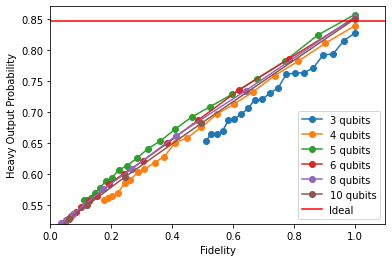

In [101]:
for count, value in enumerate(qubit_range):
    plt.plot(fids[count], hops[count], marker='o', label=str(value) + " qubits")
plt.axhline((1 + np.log(2)) / 2, color='red', label='Ideal')
plt.legend()
plt.ylim(0.52, 0.87)
plt.xlim(0.0, 1.1)
plt.xlabel("Fidelity")
plt.ylabel("Heavy Output Probability")
plt.show()

In [103]:
m, b = np.polyfit(fids[-1], hops[-1], 1)

In [104]:
m

0.3540305133257011

In [105]:
b

0.5011759309863479

In [108]:
def fid_to_hop(fid):
    return m * fid + b

def hop_to_fid(hop):
    return (hop - b) / m

In [288]:
def fidelity(s, t, i, m, num_one_qubit, num_two_qubit, init, meas):
    return np.exp(-1 * num_one_qubit * s - num_two_qubit * t - init * i - meas * m)

fid_fn = lambda x, y: fidelity(0, x, 0, 0, 0, y, 0, 0)
fid_fn1 = lambda x, y, n: fidelity(x, x, x, x, y, y, n, n)

In [359]:
error_range = np.logspace(-7.5, -1.5, 30)
#error_range = np.linspace(1e-5, 1e-3, 20)
#error_range = np.logspace(-5, -3, 30)

qvs = []

for e in error_range:
    logqv = 2
    while True:
        num_2 = (logqv / 2) * logqv
        fid = fid_fn(e, num_2)
        if fid_to_hop(fid) < 2/3:
            logqv = max(2, logqv - 1)
            break
        logqv += 1
        if logqv > 1e10:
            break
    qvs.append(logqv)
    
qvs_all_errors = []

for e in error_range:
    logqv = 2
    while True:
        num_2 = (logqv / 2) * logqv
        fid = fid_fn1(e, num_2, logqv)
        if fid_to_hop(fid) < 2/3:
            logqv = max(2, logqv - 1)
            break
        logqv += 1
        if logqv > 1e10:
            break
    qvs_all_errors.append(logqv)

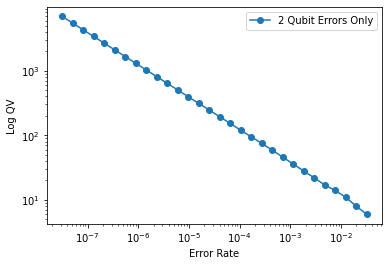

In [366]:
plt.plot(error_range, qvs, marker='o', label='2 Qubit Errors Only')
#plt.plot(error_range, qvs_all_errors, marker='o', label='1, 2 Qubit, State Prep, Meas Errors')
plt.legend()
plt.xlabel('Error Rate')
plt.ylabel('Log QV')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [361]:
#qvs = qvs_all_errors
exp_fn = lambda x, a, b: x ** a * 10**b
qv_fit = scipy.optimize.curve_fit(exp_fn, error_range, qvs, p0=(0.0, 0.0))
qv_np_fit = np.polyfit(np.log(error_range), np.log(qvs), 1, w=np.sqrt(qvs))

In [362]:
print(qv_fit)
print(qv_np_fit)

(array([-0.50021053,  0.08948566]), array([[1.70175617e-09, 1.21865374e-08],
       [1.21865374e-08, 8.75843245e-08]]))
[-0.50073546  0.19769991]


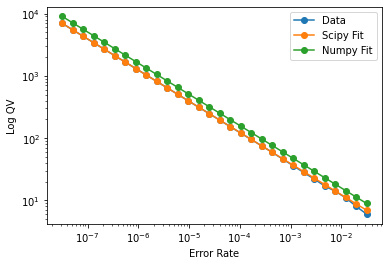

In [367]:
plt.plot(error_range, qvs, marker='o', label='Data')
plt.plot(error_range, [exp_fn(i, *qv_fit[0]) for i in error_range], marker='o', label='Scipy Fit')
plt.plot(error_range, [i ** qv_np_fit[0] * 10**qv_np_fit[1] for i in error_range], marker='o', label='Numpy Fit')
plt.xlabel('Error Rate')
plt.ylabel('Log QV')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

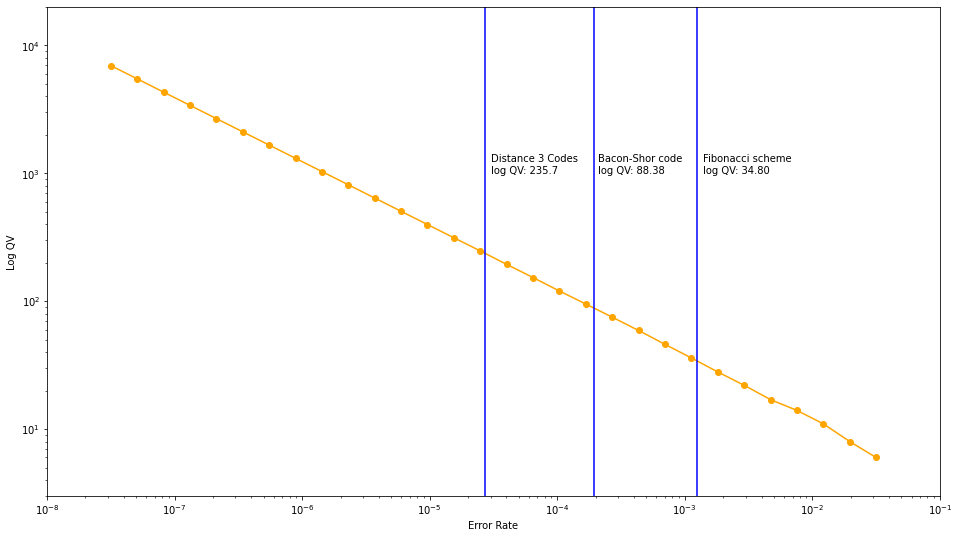

In [368]:
plt.figure(figsize=(16, 9))
plt.plot(error_range, qvs, marker='o', color='orange')

plt.axvline(2.73e-5, color='blue')
plt.text(3e-5, 1e3, 'Distance 3 Codes\nlog QV: {:.5}'.format(str(exp_fn(2.73e-5, *qv_fit[0]))))

plt.axvline(1.25e-3, color='blue')
plt.text(1.4e-3, 1e3, 'Fibonacci scheme\nlog QV: {:.5}'.format(str(exp_fn(1.25e-3, *qv_fit[0]))))

plt.axvline(1.94e-4, color='blue')
plt.text(2.1e-4, 1e3, 'Bacon-Shor code\nlog QV: {:.5}'.format(str(exp_fn(1.94e-4, *qv_fit[0]))))

plt.xlabel('Error Rate')
plt.ylabel('Log QV')
plt.xscale('log')
plt.yscale('log')
plt.ylim(3, 2e4)
plt.xlim(1e-8, 1e-1)
#plt.legend()
plt.show()